# Задача 2. Определение стоимости авто #

Ключевая метрика RMSE -  среднеквадратичная ошибка. Чтобы сдать проект значение метрики должно быть не более 2500.

# Импортируем необходимые библиотеки 

In [301]:
import warnings
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')


# Подготовка данных #

Откроем и изучим файл

In [302]:
df = pd.read_csv("autos.csv")

In [303]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим типы данных

In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Создание описательной статистики

In [305]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


# Удаление неиформативных признаков и изменение названий столбцов

удалим неинформативные признаки

In [306]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 
                  'NumberOfPictures','PostalCode', 'LastSeen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


# Работа со стилем и типами данных

изменим названия столбцов

In [307]:
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 
                'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'date_created']

изменим тип данных в столбцах, где это необходимо

In [308]:
df['date_created'] = pd.to_datetime(df['date_created'])

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              354369 non-null  int64         
 1   vehicle_type       316879 non-null  object        
 2   registration_year  354369 non-null  int64         
 3   gearbox            334536 non-null  object        
 4   power              354369 non-null  int64         
 5   model              334664 non-null  object        
 6   kilometer          354369 non-null  int64         
 7   fuel_type          321474 non-null  object        
 8   brand              354369 non-null  object        
 9   repaired           283215 non-null  object        
 10  date_created       354369 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 29.7+ MB


# Работа с пропусками

функция для построения графика, отражающего доли пропусков

In [310]:
def pass_value_barh(df):
    if df.isna().sum().sum() > 0:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(10, 8), legend = False, fontsize = 12)
            .set_title('Доля пропусков' + "\n", fontsize = 14)    
        )   
    else:
        print('Пропусков не осталось!')

визуализация доли пропусков в каждом столбце

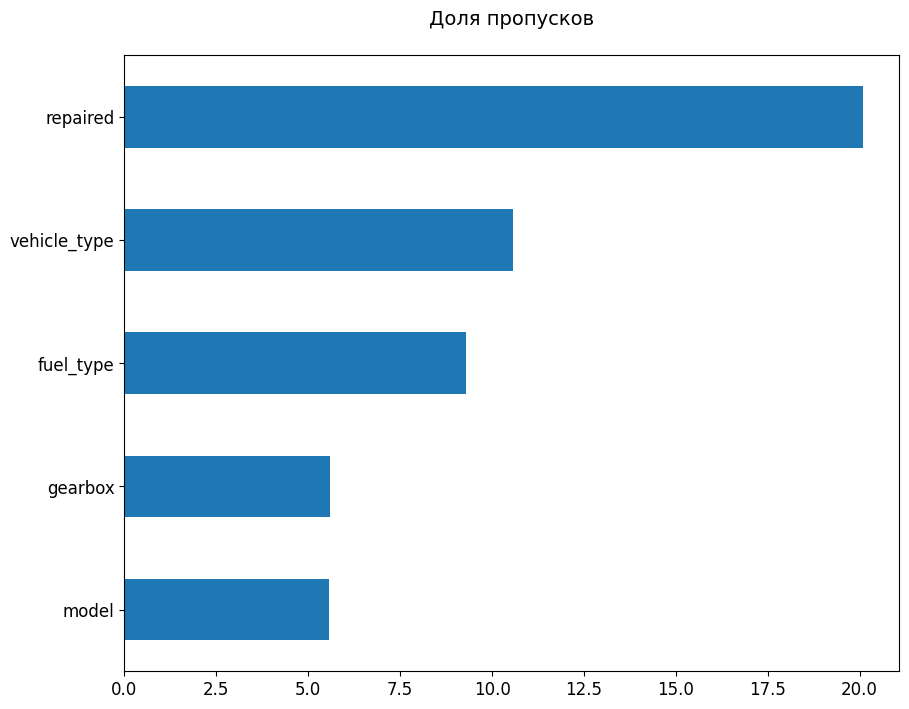

In [311]:
pass_value_barh(df)

заполним пропуски и заменим значения в столбце "repaired"

In [312]:
df['repaired'] = df['repaired'].fillna('no')
df.loc[(df.repaired == 'no'), 'repaired'] = 0
df.loc[(df.repaired == 'yes'), 'repaired'] = 1

df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,0,2016-03-24
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,1,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,2016-03-31


заполним пропуски в других столбцах

In [313]:
df = df.fillna('unknown')

In [314]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,0,2016-03-24
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,1,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0,2016-03-31


проверяем, что пропусков не осталось

In [315]:
pass_value_barh(df)

Пропусков не осталось!


В столбце, который показывает была ли машина в ремонте, заменим все пустые значения на "no". Так можно поступить, так как при заполнении данного признак, если машина не ремонтировалась, графу могли отставлять пустой. Затем поменяем значения "yes" на 1, а "no" на 0.

Все остальные столбцы с пропусками отражают категориальные признаки: тип автомобильного кузова, тип топлива, тип коробки передач, модель автомобиля. Заполним эти пропуски значением "unknown".

# Поиск и удаление дубликатов

Ищем полные дубликаты

In [316]:
df.duplicated().sum()

15062

удаляем полные дубликаты

In [317]:

df = df.drop_duplicates()

df.duplicated().sum()

0

# Работа с аномальными значениями

Посмотрим нет ли аномалий типа: год регистрации автомобиля превышает год публикации объявления

In [318]:
df.loc[df['registration_year'] > df['date_created'].dt.year].shape

(14242, 11)

удалим подобные объекты

In [319]:
df = df.loc[df['registration_year'] <= df['date_created'].dt.year]

данные по столбцу "год регистрации автомобиля"

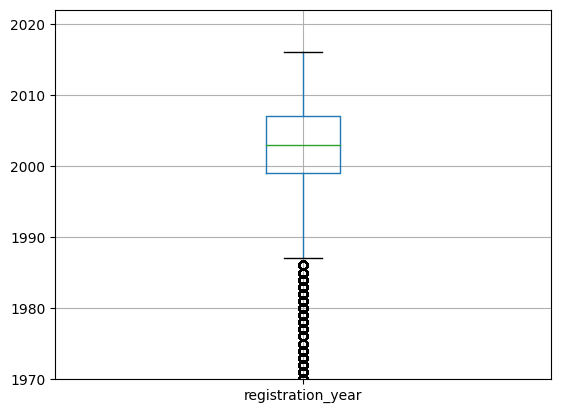

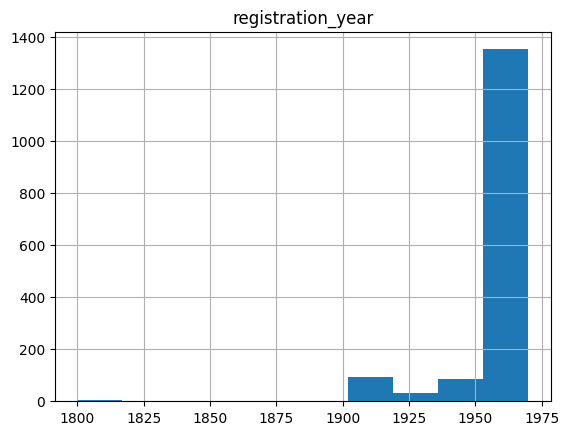

Максимальный год регистрации автомобиля: 2016


In [320]:
df.boxplot(column='registration_year')
plt.ylim(1970, 2022)             
plt.show()
df.hist(column='registration_year', range=(1800, 1970)) 
plt.show()
print(f'Максимальный год регистрации автомобиля: {df["registration_year"].max()}')

In [321]:
df = df.query('1970 <= registration_year').reset_index(drop=True)

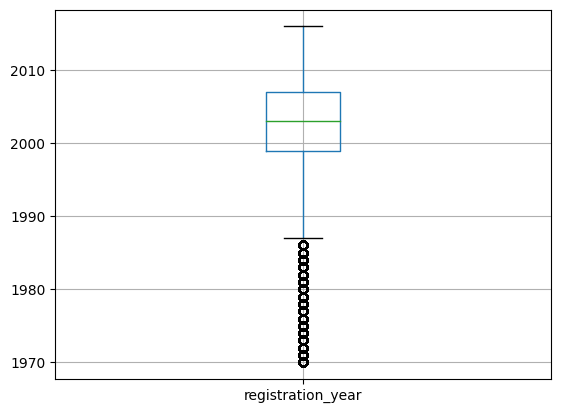

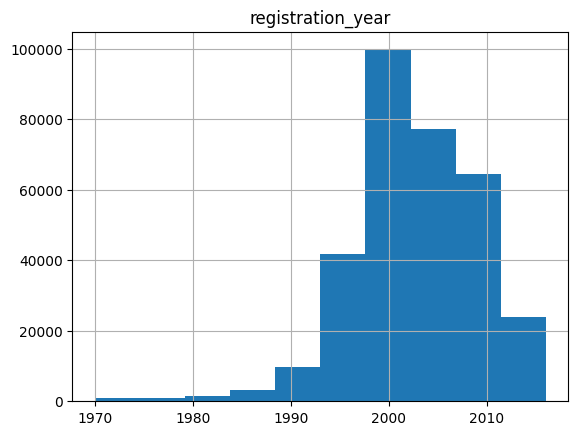

In [322]:
df.boxplot(column='registration_year')      
plt.show()
df.hist(column='registration_year') 
plt.show()

уберем столбец с датой публикации объявления, он нам больше не нужен

In [323]:
df = df.drop('date_created', axis=1)

Уберем из столбца с годом регистрации автомобиля все аномалии: удалим объявления в которых год регистрации автомобиля превышает год публикации объявления, так как мы не хотим, чтобы в выборку попали автомобили "из будущего". Установим следующую нижнюю границу – 1970 год, чтобы захватить старые автомобили. Верхняя граница – 2016 год, как максимальный год регистрации автомобиля**.

данные по столбцу "мощность (в л.с.)"

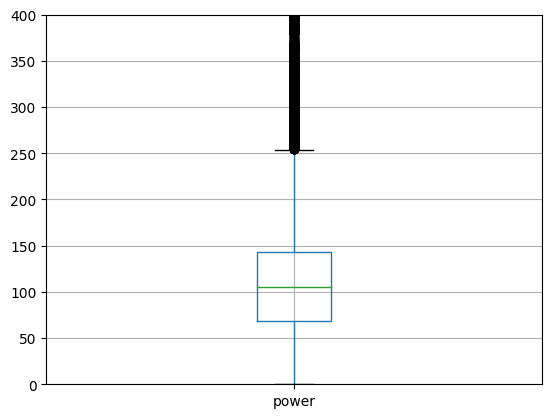

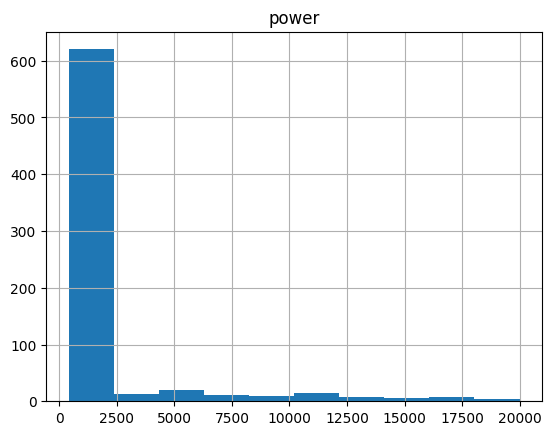

In [324]:
df.boxplot(column='power') 
plt.ylim(0, 400)
plt.show()
df.hist(column='power', range=(400, df['power'].max())) 
plt.show()

In [325]:
def normal_power(num):
    if num >= 10000:
        return num / 100
    else:
        return num

In [326]:
df['power'] = df['power'].apply(normal_power).astype(int)
df = df.query('50 <= power <= 400').reset_index(drop=True)

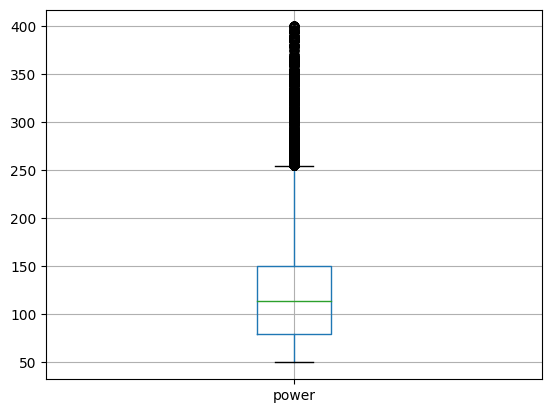

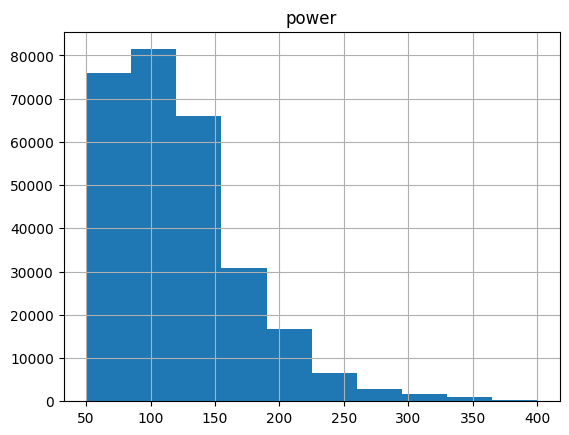

In [327]:
df.boxplot(column='power') 
plt.show()
df.hist(column='power') 
plt.show()

Уберем из столбца с мощностью автомобиля все аномалии. Значения выше 10 тыс. л.с. точно являются таковыми. Разделим все значения выше этого на 100. Кроме того согласно диаграмме размаха значения выше 250 л.с. и ниже 70 л.с. уже выходят за пределы "усов". Оставим только объекты со значениями в промежутке от 50 л.с. до 400 л.с., чтобы захватить как маломощные автомобили, так и машины с высокой мощностью.

данные по столбцу "пробег"

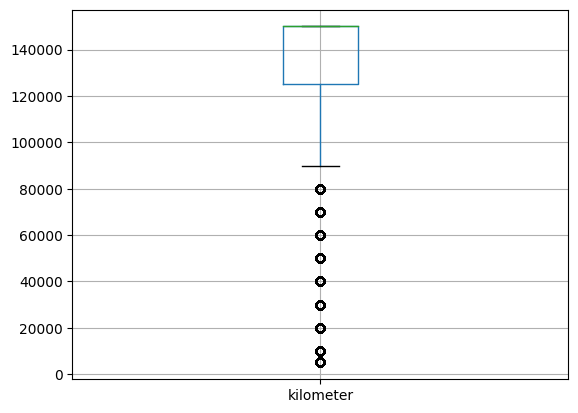

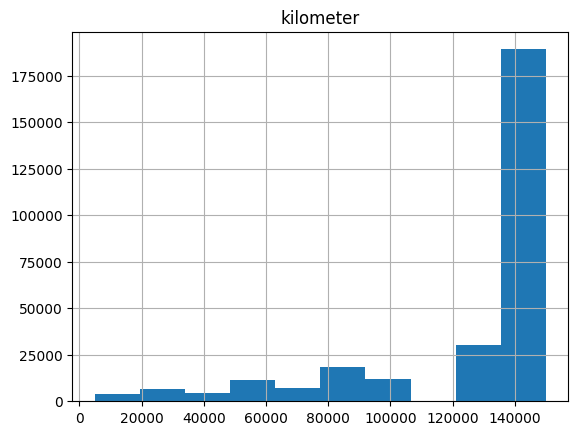

Уникальные значения столбца с пробегом: [125000, 150000, 90000, 40000, 30000, 70000, 100000, 60000, 5000, 20000, 80000, 50000, 10000]


In [328]:
df.boxplot(column='kilometer') 
plt.show()
df.hist(column='kilometer') 
plt.show()
print(f'Уникальные значения столбца с пробегом: {list(df["kilometer"].unique())}')

На графиках видно, что большое количество автомобилей имеют пробег от 120 до 150 тыс. км., что вполне ожидаемо для рынка авто с пробегом. Однако это не значит, что не может быть машин с очень маленьким пробегом, поэтому не будем убирать аномалии по данному столбцу.

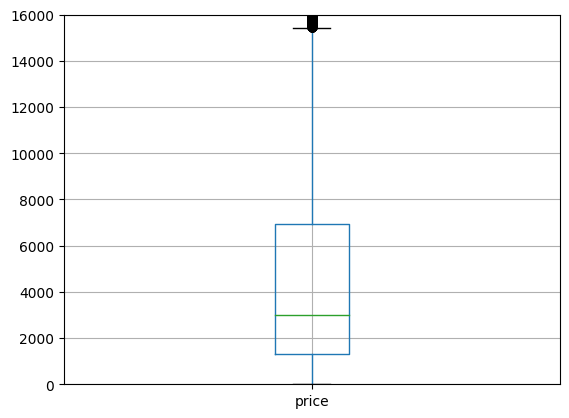

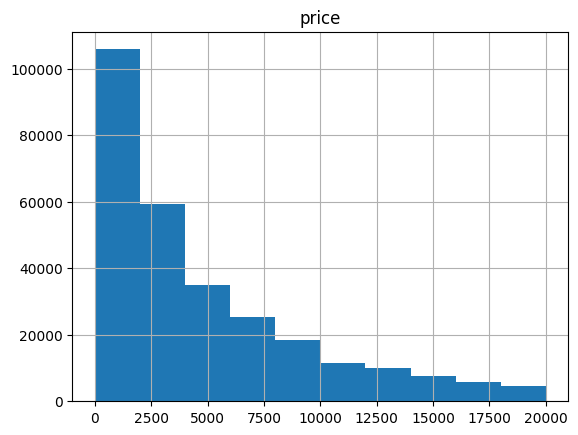

In [329]:
df.boxplot(column='price') 
plt.ylim(0, 16000)
plt.show()
df.hist(column='price') 
plt.show()

In [330]:
df = df.query('0 < price <= 16000')

данные по столбцу "цена

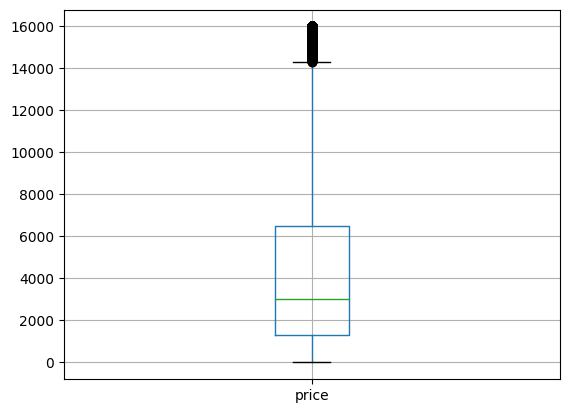

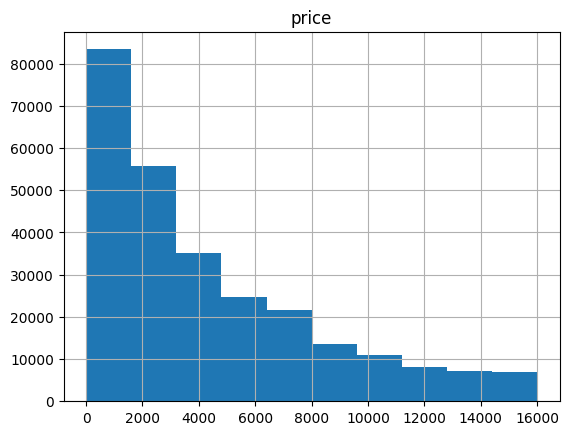

In [331]:
df.boxplot(column='price') 
plt.show()
df.hist(column='price') 
plt.show()

Удалим аномалии из столбца с целевым признаком – "цена". К аномалиям относятся все значения выше верхней границы "усов".

# Изучение корреляции признаков

Преобразование категориальных переменных в числовой формат

In [332]:
le = LabelEncoder()
df_encoded = df.copy()
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    df_encoded[column] = le.fit_transform(df[column])

Построение тепловой карты

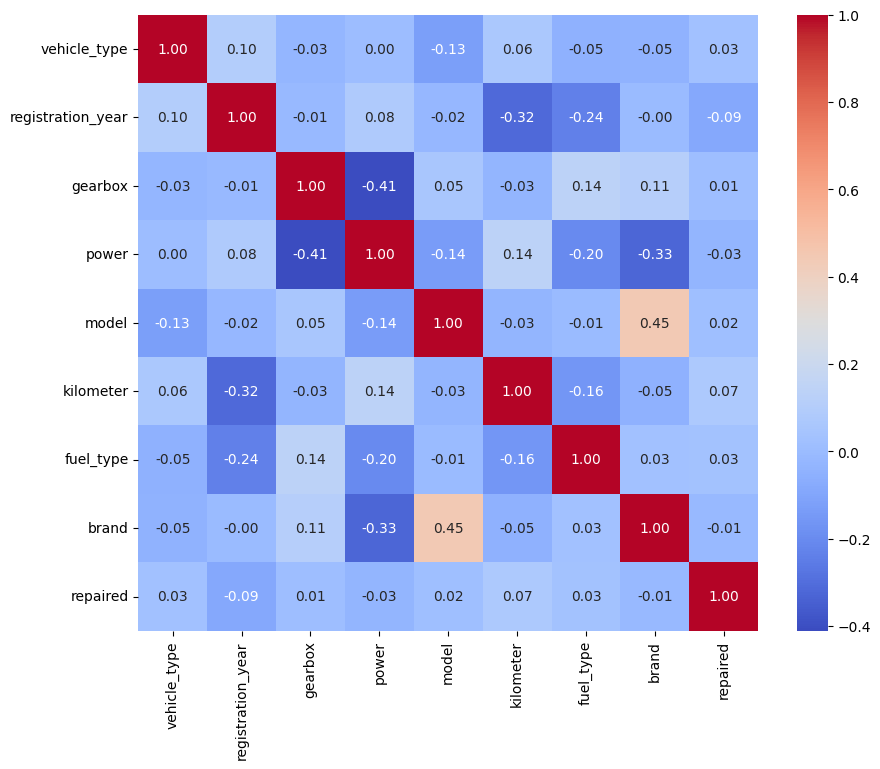

In [333]:


plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.drop('price', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


Значение коффициента корреляции между численными признаками не привышает 0.2 – 0.3. Такая корреляция считается слабой, следовательно мультиколлинеарности нет.

# Подготовка выборок для обучения моделей

описание данных после предобработки

In [334]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 267273 entries, 1 to 283245
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              267273 non-null  int64 
 1   vehicle_type       267273 non-null  object
 2   registration_year  267273 non-null  int64 
 3   gearbox            267273 non-null  object
 4   power              267273 non-null  int32 
 5   model              267273 non-null  object
 6   kilometer          267273 non-null  int64 
 7   fuel_type          267273 non-null  object
 8   brand              267273 non-null  object
 9   repaired           267273 non-null  int64 
dtypes: int32(1), int64(4), object(5)
memory usage: 21.4+ MB


разделим данные на выборки

In [335]:
features_train, features_test, target_train, target_test = train_test_split(df.drop('price', axis=1),
                                                                            df['price'],
                                                                            test_size=0.25, 
                                                                            random_state=42)

проверим размеры выборок

In [336]:
display(features_train.shape, target_train.shape)
display(features_test.shape, target_test.shape)

(200454, 9)

(200454,)

(66819, 9)

(66819,)

# Обучение моделей

категориальные признаки

In [337]:
CATEGORICAL = features_train.select_dtypes(include='object').columns.to_list()
CATEGORICAL

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

численные признаки

In [338]:
NUMERIC = features_train.select_dtypes(exclude='object').columns.to_list()
NUMERIC.remove('repaired')
NUMERIC

['registration_year', 'power', 'kilometer']

заготовка для сводной таблицы по всем моделям

In [339]:
rmse_score_diff_methods = pd.DataFrame()

# Базовые модели
# Логистическая регрессия (Ridge)
Используем OHE кодирование категориальных признаков и StandardScaler для численных признаков.

Кодировка категориальных признаков и маштабирование численных

In [340]:
features_train_ridge = features_train.copy()

col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        CATEGORICAL
    ),
    (
        StandardScaler(), 
        NUMERIC
    ),
    remainder='passthrough')

In [341]:
%%time

model_ridge = Ridge(random_state=42)

pipeline_ridge = make_pipeline(col_transformer_ridge, model_ridge)

params_grid_ridge = {'ridge__alpha': np.arange(0.00, 0.25, 0.01)}

grid_ridge = GridSearchCV(
    pipeline_ridge, 
    param_grid=params_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=1)

grid_ridge.fit(features_train_ridge, target_train)

best_model_ridge = grid_ridge.best_estimator_
best_parametrs_ridge = grid_ridge.best_params_
best_result_ridge = grid_ridge.best_score_ * -1

Fitting 5 folds for each of 25 candidates, totalling 125 fits


CPU times: total: 15.3 s
Wall time: 45.6 s


In [343]:
print(f'Лучший результат RMSE модели: {best_result_ridge}') #
print(f'Лучшие параметры модели: {best_parametrs_ridge}') 

Лучший результат RMSE модели: 2188.3065326610604
Лучшие параметры модели: {'ridge__alpha': 0.22}


замеряем время предсказания

In [344]:
%%time

predicted_test = best_model_ridge.predict(features_train)

CPU times: total: 172 ms
Wall time: 167 ms


In [345]:
rmse_score_diff_methods.loc['Ridge', 'RMSE'] = best_result_ridge
rmse_score_diff_methods.loc['Ridge', 'time_fit'] = '1 min 30 s'
rmse_score_diff_methods.loc['Ridge', 'time_predict'] = '439 ms'

# Дерево решений